In [2]:
import json
import os
import requests

url = "http://127.0.0.1:8001/inference/process"
file_path = 'c:/Users/wbrya/OneDrive/Documents/GitHub/ocr-inference/dataset/10k_tesla_3_pages.pdf'

with open(file_path, "rb") as f:
    filename = os.path.basename(file_path)
    files = {
        'file': (
            filename,
            f,
            'application/pdf'  # explicitly tell the server it's a PDF
        )
    }
    response = requests.post(url, files=files)
try:
    data = response.json()
    print(json.dumps(data, indent=2))
except Exception as e:
    print("Status code:", response.status_code)
    print("Response text:", response.text)
    print("Error decoding JSON:", e)

[
  {
    "text": "UNITED STATES",
    "box": [
      [
        466.0,
        117.0
      ],
      [
        757.0,
        117.0
      ],
      [
        757.0,
        157.0
      ],
      [
        466.0,
        157.0
      ]
    ],
    "confidence": 0.9991188049316406,
    "page_number": 1
  },
  {
    "text": "SECURITIES AND EXCHANGE COMMISSION",
    "box": [
      [
        221.0,
        163.0
      ],
      [
        999.0,
        163.0
      ],
      [
        999.0,
        198.0
      ],
      [
        221.0,
        198.0
      ]
    ],
    "confidence": 0.9990180730819702,
    "page_number": 1
  },
  {
    "text": "Washington, D.C. 20549",
    "box": [
      [
        482.0,
        196.0
      ],
      [
        742.0,
        196.0
      ],
      [
        742.0,
        233.0
      ],
      [
        482.0,
        233.0
      ]
    ],
    "confidence": 0.9835562109947205,
    "page_number": 1
  },
  {
    "text": "FORM 10-K",
    "box": [
      [
        509.0,
   

In [3]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\wbrya\OneDrive\Documents\GitHub\ocr-inference\.venv\Scripts\python.exe -m pip install --upgrade pip


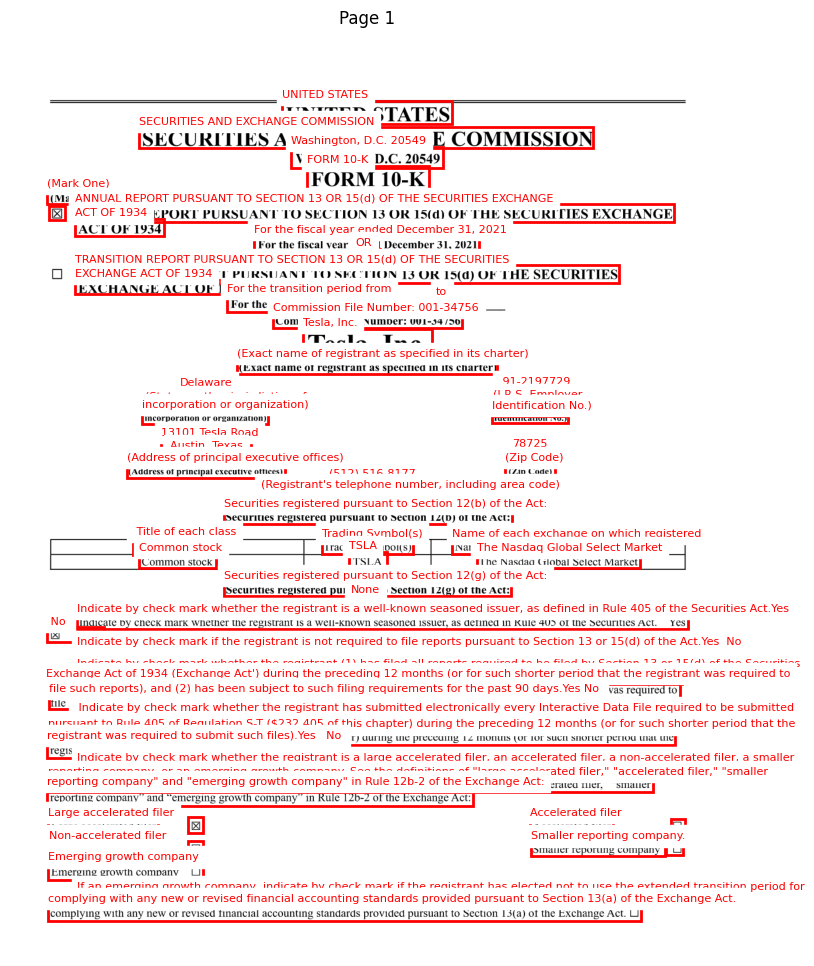

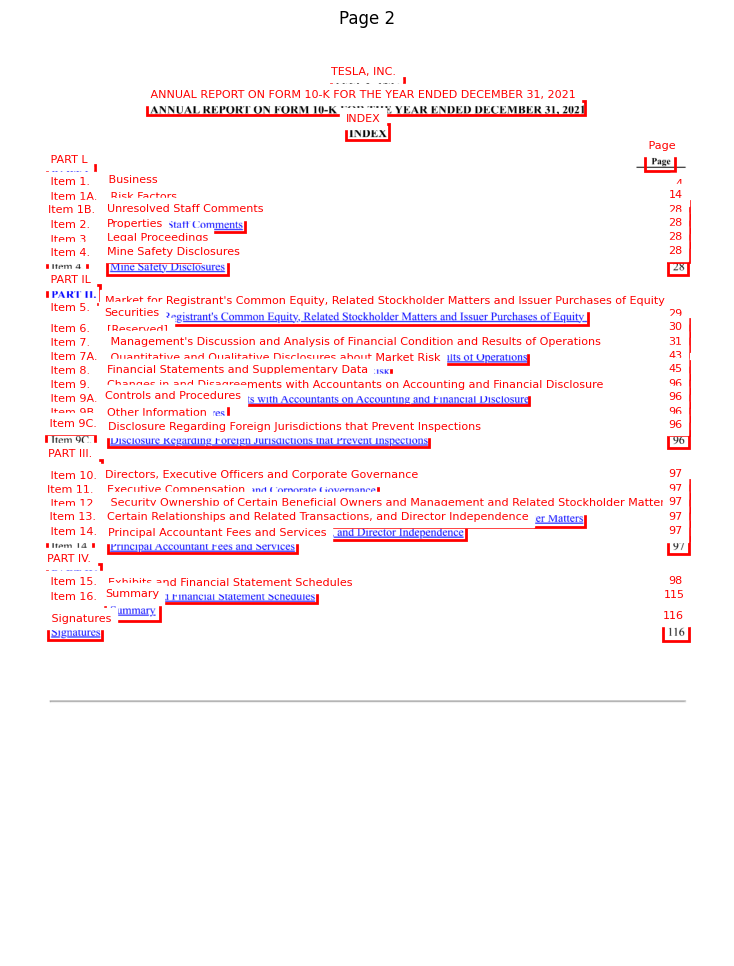

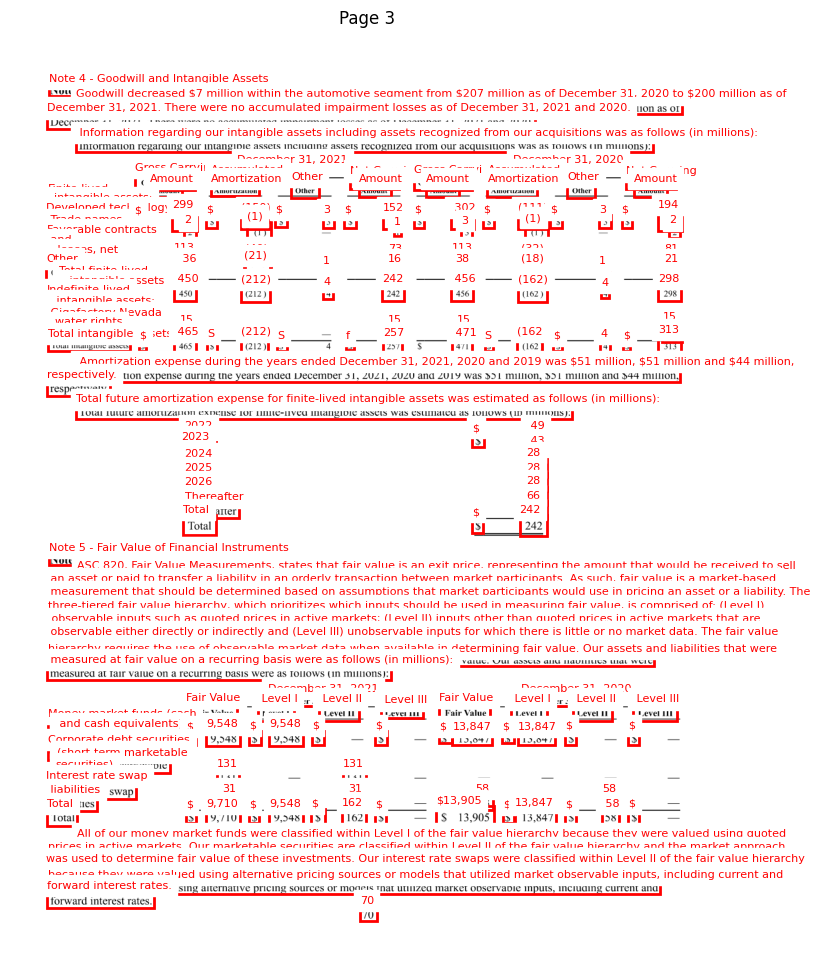

In [4]:
import io
import fitz  # PyMuPDF
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

# Helper function to render a PDF page as an image
def pdf_page_to_image(file_path, page_number=0, zoom=2):
    doc = fitz.open(file_path)
    try:
        page = doc.load_page(page_number)
        matrix = fitz.Matrix(zoom, zoom)
        pixmap = page.get_pixmap(matrix=matrix)
        image_data = pixmap.tobytes("png")
        image = Image.open(io.BytesIO(image_data))
    finally:
        doc.close()
    return image

# Open the PDF to get the number of pages
pdf_doc = fitz.open(file_path)
num_pages = pdf_doc.page_count
pdf_doc.close()

# Group bounding boxes by page_number (1-based in your JSON)
page_boxes = defaultdict(list)
if isinstance(data, list):
    for item in data:
        page_idx = item.get('page_number', 1) - 1  # Convert to 0-based index
        page_boxes[page_idx].append(item)
else:
    page_boxes[0] = []

# Loop through all pages and plot bounding boxes for each
for page_number in range(num_pages):
    img = pdf_page_to_image(file_path, page_number=page_number, zoom=2)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    # Draw bounding boxes for this page
    for item in page_boxes.get(page_number, []):
        box = item.get('box')
        if box and len(box) == 4:
            xs = [pt[0] for pt in box]
            ys = [pt[1] for pt in box]
            min_x, min_y = min(xs), min(ys)
            max_x, max_y = max(xs), max(ys)
            rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(min_x, min_y - 5, item.get('text', ''), color='red', fontsize=8, backgroundcolor='white')
    ax.set_title(f"Page {page_number + 1}")
    plt.axis('off')
    plt.show()